In [1]:
# -*- coding: utf-8 -*-
"""

This script performs the following tasks:

1. Uses as input the weights from a run of the Convolutional Variational Autoencoder (CVAE) from the TensorFlow tutorial.
2. Uses as input the latent space of the MNIST dataset encoded through CVAE.

The script implements both the encoder and decoder as functions.

Authors:
- Gabriel Turinici
- Tiffany Zeitoun
- Dan Winzsman
- Benjamin Krief
"""

# Import necessary libraries for deep learning, visualization, and data processing
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # For displaying progress bars during training or data loading
import pandas as pd  # For handling data operations and analysis

In [2]:
# Print a message indicating the download process is starting
print('Downloading necessary files')

# Import the requests library for handling file downloads
import requests

# Base URL for downloading the required files
base_url = 'https://github.com/gabriel-turinici/Huber-energy-measure-quantization/raw/main/diversity_in_generative_ai/'

# List of file names to be downloaded
files_names = ['my_checkpoint.index', 'reparam.npz', 'my_checkpoint.data-00000-of-00001']

# Loop through the list of files and download each one
for fl in files_names:
    print(f'Downloading {fl} from {base_url}')  # Inform the user which file is being downloaded
    response = requests.get(base_url + fl)  # Send a request to download the file
    with open(fl, mode="wb") as file:  # Open the file in write-binary mode
        file.write(response.content)  # Write the downloaded content to the file


download necessary files
downloading my_checkpoint.index from https://github.com/gabriel-turinici/Huber-energy-measure-quantization/raw/main/diversity_in_generative_ai/
downloading reparam.npz from https://github.com/gabriel-turinici/Huber-energy-measure-quantization/raw/main/diversity_in_generative_ai/
downloading my_checkpoint.data-00000-of-00001 from https://github.com/gabriel-turinici/Huber-energy-measure-quantization/raw/main/diversity_in_generative_ai/


In [3]:
def preprocess_images(images):
    """
    Preprocess the input images by reshaping and normalizing pixel values.

    Args:
        images (numpy array): Array of images to be preprocessed.

    Returns:
        numpy array: Preprocessed images, reshaped to (28, 28, 1) and normalized to float32.
    """
    # Reshape the images to add a channel dimension (28x28 images with 1 channel)
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.0  # Normalize pixel values to [0, 1] range
    
    return images.astype('float32')


In [12]:
# Load and preprocess the MNIST dataset
print('Loading MNIST dataset and preprocessing images')

# Load the MNIST dataset from TensorFlow's built-in datasets (we only need the images, not the labels)
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

# Define a function to preprocess MNIST images
def preprocess_images(images):
    """
    Preprocess the input images by reshaping, normalizing, and binarizing pixel values.

    Args:
        images (numpy array): Array of images to preprocess.

    Returns:
        numpy array: Preprocessed images, reshaped to (28, 28, 1), normalized and binarized.
    """
    # Reshape the images to add a channel dimension (28x28 images with 1 channel) and normalize pixel values
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.0

    # Binarize pixel values: set values > 0.5 to 1.0 and others to 0.0
    return np.where(images > 0.5, 1.0, 0.0).astype('float32')

# Preprocess the training and testing images
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

# Display the shape of the preprocessed training images
print('Shape of preprocessed train_images:', train_images.shape)


load mnist, preprocess images
train_image.shape= (60000, 28, 28, 1)


In [13]:
N = 2  # Ambient dimension for latent space

class CVAE(tf.keras.Model):
    """Convolutional Variational Autoencoder (CVAE) class definition."""

    def __init__(self, latent_dim):
        """
        Initialize the CVAE model.
        
        Args:
            latent_dim (int): Dimensionality of the latent space.
        """
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Define the encoder network as a Sequential model
        self.encoder = tf.keras.Sequential(
            [
                # Input layer: shape of the input is (28, 28, 1) for MNIST images
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                
                # Flatten the input image into a 1D vector
                tf.keras.layers.Flatten(),
                
                # Add 5 fully connected layers with ReLU activation
                *[tf.keras.layers.Dense(28 * 28, activation='relu') for _ in range(5)],
                
                # The final layer outputs both mean and log variance for reparameterization
                tf.keras.layers.Dense(latent_dim + latent_dim)  # Output latent_dim for mean and logvar
            ]
        )

        # Define the decoder network as a Sequential model
        self.decoder = tf.keras.Sequential(
            [
                # Input layer: latent space input of shape (latent_dim,)
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),

                # Flatten the latent vector (though it's already 1D in this case)
                tf.keras.layers.Flatten(),

                # Add fully connected layers to reconstruct the original image
                *[tf.keras.layers.Dense(28 * 28, activation='relu') for _ in range(4)],

                # The final layer reshapes the output back to (28, 28, 1) for the image
                tf.keras.layers.Dense(28 * 28),  # Output logits without activation
                tf.keras.layers.Reshape((28, 28, 1))  # Reshape the output to match the original image size
            ]
        )

    @tf.function
    def sample(self, eps=None):
        """
        Generate samples from the latent space by decoding random or given points.

        Args:
            eps (tensor, optional): Latent space points. If not provided, random points are sampled.
        
        Returns:
            tensor: Decoded output from latent space points, typically images.
        """
        if eps is None:
            # If no latent points are provided, generate random points from a normal distribution
            eps = tf.random.normal(shape=(100, self.latent_dim))
        
        # Decode the latent space points into images
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        """
        Encodes the input images into the latent space.
        
        Args:
            x (tensor): Input image data.
        
        Returns:
            tuple: Mean and log variance of the encoded latent variables.
        """
        # Split the encoder output into mean and log variance for the latent space
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        """
        Reparameterization trick to sample from a normal distribution using the mean and log variance.
        
        Args:
            mean (tensor): Mean of the latent variables.
            logvar (tensor): Log variance of the latent variables.
        
        Returns:
            tensor: Sampled latent variables.
        """
        # Sample random noise from a standard normal distribution
        eps = tf.random.normal(shape=mean.shape)
        
        # Reparameterize to generate latent variables
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        """
        Decodes the latent variables back into images.
        
        Args:
            z (tensor): Latent variables.
            apply_sigmoid (bool, optional): Whether to apply the sigmoid function to the output.
        
        Returns:
            tensor: Decoded output, typically images.
        """
        # Pass the latent variables through the decoder network to reconstruct images
        logits = self.decoder(z)

        # Apply sigmoid activation if specified (useful for binary outputs)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        
        return logits  # Return the raw logits if no sigmoid is applied


In [14]:
latent_dim = 2  # Set the dimensionality of the latent space

# Create a new instance of the CVAE model
print('Creating a new CVAE model instance')
model = CVAE(latent_dim)

# Generate a sample from the model using a random latent vector
res = model.sample(np.random.randn(1, latent_dim))  # Sampling from a random latent vector

# Uncomment the following line if you want to generate and save images using a custom function
# generate_and_save_images(model, 0, test_sample)

# Set the model's 'built' attribute to True to allow loading weights
model.built = True

# Restore the model weights from a checkpoint
print('Restoring model weights from checkpoint')

# Ensure that you are in the correct directory where the "my_checkpoint.index" file is located
model.load_weights("./my_checkpoint")


Create a new model instance
restore weights


In [15]:
def decoder_function(latent, digit_size=28):
    """
    Decoder function: Takes a latent vector as input and outputs a 28x28 image.
    
    Args:
        latent (tensor): Latent vector of shape (latent_dim,).
        digit_size (int): Size of the output image, default is 28 (for 28x28 image).
    
    Returns:
        tensor: Decoded image of shape (digit_size, digit_size).
    """
    # Ensure the latent vector has the correct shape
    assert latent.shape == (latent_dim,), 'Error: input latent vector has incorrect shape'
    
    # Pass the latent vector through the model's decoder to generate the image
    x_decoded = model.sample(latent[None, :])  # Add batch dimension
    
    # Reshape the output into a 28x28 image
    digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
    
    return digit


def encoder_function(image, digit_size=28):
    """
    Encoder function: Takes an image as input and outputs a latent vector.
    
    Args:
        image (tensor): Input image of shape (digit_size, digit_size).
        digit_size (int): Size of the input image, default is 28 (for 28x28 image).
    
    Returns:
        tensor: Latent vector of shape (latent_dim,).
    """
    # Ensure the input image has the correct shape
    assert image.shape == (digit_size, digit_size), 'Error: input image has incorrect shape'
    
    # Reshape the image to add the necessary batch and channel dimensions, then pass through the encoder
    res = model.encoder(tf.reshape(image, (1, digit_size, digit_size, 1)))  # Add batch and channel dimensions
    
    # Return the latent vector (taking only the first 'latent_dim' values)
    return res[0, :latent_dim]


In [16]:
# Adjust the display options for NumPy arrays
np.set_printoptions(threshold=np.inf, linewidth=np.inf)  # Ensures full array output without truncation

# Load the NumPy array from the 'reparam.npz' file
with np.load('reparam.npz', allow_pickle=True) as data:
    reparam = data['reparam']  # Extract the 'reparam' array from the file

# Uncomment the line below if you wish to print the entire first element of the array
# print(reparam[0])

In [94]:
def create_list_sub_txt(huge_list, filepath=''):
    """
    Save a list of sublists to a text file, each sublist written on a new line.

    Args:
        huge_list (list of lists): The list containing sublists to save.
        filepath (str): The path where the file will be saved.
    """
    with open(filepath, 'w') as file:
        # Write each sublist to the file, formatting it as a string
        for sublist in huge_list:
            file.write('[' + ', '.join(map(str, sublist)) + ']\n')


def create_list_txt(simple_list, filepath=''):
    """
    Save a simple list to a text file, all elements on the same line.

    Args:
        simple_list (list): The list of elements to save.
        filepath (str): The path where the file will be saved.
    """
    with open(filepath, 'w') as file:
        # Write the simple list to the file as a single line, separated by commas
        file.write(', '.join(map(str, simple_list)) + '\n')


In [104]:
from google.colab import files
from google.colab import drive
import ast
import numpy as np

# Mount Google Drive to access files
drive.mount('/content/drive')

# Function to retrieve solutions from a file
def recup_solutions(filepath=''):
    """
    Retrieve solutions from a file where each line contains a list of values.

    Args:
        filepath (str): Path to the file containing the solutions.

    Returns:
        list: A list of parsed solutions.
    """
    with open(filepath, 'r') as file:
        # Parse each line as a Python object (list)
        solutions = [ast.literal_eval(line.strip()) for line in file]
    return solutions

# Function to retrieve a list of floats from a comma-separated file
def recup_da_floats(filepath):
    """
    Retrieve a list of float values from a file where values are comma-separated.

    Args:
        filepath (str): Path to the file containing comma-separated float values.

    Returns:
        list: A list of floats.
    """
    with open(filepath, 'r') as file:
        # Split the file content by commas and convert to floats
        data = file.read().strip().split(',')
        float_list = [float(x) for x in data]
    return float_list

# Filepaths for various data files
filepath_final_errors = '/content/drive/My Drive/Thesis/data/final_errors.txt'
filepath_deltas = '/content/drive/My Drive/Thesis/data/deltas.txt'
filepath_solutions = '/content/drive/My Drive/Thesis/data/solutions.txt'
filepath_reparam = '/content/drive/My Drive/Thesis/data/reparam.txt'
filepath_bonus = '/content/drive/My Drive/Thesis/data/bonus.txt'

# Retrieve data from the respective files
final_errors = recup_da_floats(filepath_final_errors)  # List of final errors
deltas = recup_da_floats(filepath_deltas)  # List of deltas
solutions = recup_solutions(filepath_solutions)  # List of solutions (parsed)
reparam = np.array(recup_solutions(filepath_reparam))  # Convert reparam solutions to a numpy array
bonus = np.array(recup_solutions(filepath_bonus))  # Convert bonus solutions to a numpy array


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from tensorflow.keras import layers, models

# Define a sequential model for image classification (e.g., MNIST)
model_bis = models.Sequential([
    # Reshape input to match the expected dimensions for Conv2D layers (28x28x1)
    layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    
    # First convolutional layer with 32 filters and ReLU activation
    layers.Conv2D(32, (3, 3), activation='relu'),
    
    # Max pooling to down-sample the feature maps
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional layer with 64 filters and ReLU activation
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    # Max pooling to down-sample the feature maps
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional layer with 64 filters and ReLU activation
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    # Flatten the feature maps into a single vector
    layers.Flatten(),
    
    # Dense layer with 64 units and ReLU activation
    layers.Dense(64, activation='relu'),
    
    # Output layer with 10 units (for 10 classes) and softmax activation
    layers.Dense(10, activation='softmax')
])

# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
model_bis.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model architecture
model_bis.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)         

In [21]:
# Train the model on the training data for 10 epochs and validate on the test data
model_bis.fit(
    train_images,  # Training images
    train_labels,  # Training labels
    epochs=10,  # Number of epochs for training
    validation_data=(test_images, test_labels)  # Validation data (test set)
)


Epoch 1/10
1875/1875 [==============================] - 56s 29ms/step - loss: 0.1460 - accuracy: 0.9549 - val_loss: 0.0558 - val_accuracy: 0.9806
Epoch 2/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0491 - accuracy: 0.9848 - val_loss: 0.0392 - val_accuracy: 0.9883
Epoch 3/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0355 - accuracy: 0.9890 - val_loss: 0.0390 - val_accuracy: 0.9865
Epoch 4/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.0404 - val_accuracy: 0.9873
Epoch 5/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0201 - accuracy: 0.9934 - val_loss: 0.0435 - val_accuracy: 0.9884
Epoch 6/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0167 - accuracy: 0.9944 - val_loss: 0.0376 - val_accuracy: 0.9888
Epoch 7/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0312 -

In [22]:
# Evaluate the model on the test data to get the loss and accuracy
test_loss, test_acc = model_bis.evaluate(test_images, test_labels)

# Print the test accuracy
print(f"Test accuracy: {test_acc}")


313/313 [==============================] - 4s 13ms/step - loss: 0.0412 - accuracy: 0.9900
Test accuracy: 0.9900000095367432


In [105]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf

# Function to decode the latent space and apply a threshold filter to the decoded images
def decoding_filtered(latent_space):
    """
    Decode the latent space into binary images by applying a threshold of 0.5.

    Args:
        latent_space (list or array): Latent space points to decode.

    Returns:
        np.array: Decoded images as binary images (0.0 or 1.0).
    """
    list_decoded = []
    
    # Iterate over each latent space point and decode it
    for point in tqdm(latent_space):
        y = tf.Variable(point)  # Convert latent space point into a TensorFlow variable
        new_image = decoder_function(y)  # Decode the point into an image
        
        # Apply thresholding (values > 0.5 become 1.0, otherwise 0.0)
        list_decoded.append(np.where(np.array(new_image) > 0.5, 1.0, 0.0))
    
    return np.array(list_decoded)

# Main execution block
if __name__ == "__main__":
    # Decode and reshape the first 5000 images from different latent spaces
    MT_images = decoding_filtered(reparam[:5000]).reshape(5000, 28, 28, 1)  # Pr. Turinici's latent space
    MN_images = decoding_filtered(solutions).reshape(5000, 28, 28, 1)  # Post-gradient-descent latent space
    MB_images = decoding_filtered(bonus).reshape(5000, 28, 28, 1)  # Bonus latent space
    
    # Predict class probabilities for the decoded images using the trained model
    predictions_MT_dataset = model_bis.predict(MT_images)  # Predictions for MT_images
    predictions_MN_dataset = model_bis.predict(MN_images)  # Predictions for MN_images
    predictions_MB_dataset = model_bis.predict(MB_images)  # Predictions for MB_images
    predictions_mnist_dataset = model_bis.predict(train_images)  # Predictions for the original MNIST training images


100%|██████████| 5000/5000 [00:14<00:00, 340.35it/s]


1875/1875 [==============================] - 14s 8ms/step


In [106]:
from tqdm import tqdm
import numpy as np

# Function to associate the predicted class to each image
def associate_image_to_number(predictions):
    """
    Convert the predicted class probabilities into the predicted number (class label).

    Args:
        predictions (list or array): The class probabilities for each image.

    Returns:
        list: The predicted class labels (numbers) for each image.
    """
    result = []
    
    # Iterate over each image's predictions and find the class with the highest probability
    for image in tqdm(predictions):
        predicted_number = np.argmax(image)  # The index with the maximum value corresponds to the predicted class
        result.append(predicted_number)
    
    return result

# Main execution block
if __name__ == "__main__":
    # Uncomment these lines to process predictions and store results
    
    # MNIST_results = associate_image_to_number(predictions_mnist_dataset)
    # MT_results = associate_image_to_number(predictions_MT_dataset)
    # MN_results = associate_image_to_number(predictions_MN_dataset)
    # MB_results = associate_image_to_number(predictions_MB_dataset)

    # File paths for saving results
    # filepath_MNIST_results = '/content/drive/My Drive/Thesis/data/MNIST_results.txt'
    # filepath_MT_results = '/content/drive/My Drive/Thesis/data/MT_results.txt'
    # filepath_MN_results = '/content/drive/My Drive/Thesis/data/MN_results.txt'
    # filepath_MB_results = '/content/drive/My Drive/Thesis/data/MB_results.txt'

    # Save the predicted class labels to respective files
    # create_list_txt(MNIST_results, filepath_MNIST_results)
    # create_list_txt(MT_results, filepath_MT_results)
    # create_list_txt(MN_results, filepath_MN_results)
    # create_list_txt(MB_results, filepath_MB_results)


100%|██████████| 5000/5000 [00:00<00:00, 317899.62it/s]


In [110]:

# Define file paths for the results of each model and the ground truth labels
filepath_MNIST_results = '/content/drive/My Drive/Thesis/data/MNIST_results.txt'  # Ground truth labels
filepath_MT_results = '/content/drive/My Drive/Thesis/data/MT_results.txt'  # Predictions from model MT
filepath_MN_results = '/content/drive/My Drive/Thesis/data/MN_results.txt'  # Predictions from model MN
filepath_MB_results = '/content/drive/My Drive/Thesis/data/MB_results.txt'  # Predictions from model MB

# Load the results from the text files into NumPy arrays
MNIST_results = np.array(recup_da_floats(filepath_MNIST_results))
MT_results = np.array(recup_da_floats(filepath_MT_results))
MN_results = np.array(recup_da_floats(filepath_MN_results))
MB_results = np.array(recup_da_floats(filepath_MB_results))

def accuracy(ground_truth, predictions):
    """
    Calculate the accuracy of a model's predictions compared to the ground truth labels.

    Args:
        ground_truth (array-like): The true labels.
        predictions (array-like): The predicted labels from the model.

    Returns:
        float: The accuracy of the predictions as a percentage.
    """
    # Ensure inputs are NumPy arrays for efficient computation
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    
    # Check if the lengths of the inputs match
    if len(ground_truth) != len(predictions):
        raise ValueError("The number of ground truth labels and predictions must be the same.")
    
    # Calculate the number of correct predictions
    correct_predictions = np.sum(ground_truth == predictions)
    total_predictions = len(predictions)
    accuracy_percentage = (correct_predictions / total_predictions) * 100

    # Print the accuracy result
    print(f"Your model was right {correct_predictions} out of {total_predictions} images (i.e., {accuracy_percentage:.2f}%)")
    
    return accuracy_percentage

if __name__ == "__main__":
    # Calculate and print the accuracy for each model
    print("Accuracy of MT model:")
    accuracy_MT = accuracy(MNIST_results, MT_results)
    
    print("\nAccuracy of MN model:")
    accuracy_MN = accuracy(MNIST_results, MN_results)
    
    print("\nAccuracy of MB model:")
    accuracy_MB = accuracy(MNIST_results, MB_results)


Your model was right 4176 out of 5000 images (ie. 0.8352 %)
Your model was right 4304 out of 5000 images (ie. 0.8608 %)
Your model was right 4184 out of 5000 images (ie. 0.8368 %)


La classe prédite pour l'image n°555 est: 2


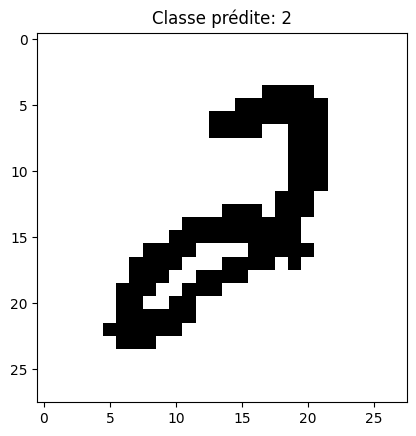

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Example index for the MNIST dataset
mnist_index = 555

# Get the predicted class by finding the index of the maximum probability
predicted_class = np.argmax(predictions_mnist_dataset[mnist_index])  # Indices start at 0 in Python

# Print the predicted class for the specified MNIST image
print(f"La classe prédite pour l'image n°{mnist_index} est: {predicted_class}")

# Display the original MNIST image
plt.imshow(train_images[mnist_index], cmap=plt.cm.binary)
plt.title(f"Classe prédite: {predicted_class}")
plt.axis('off')  # Optional: Turn off axis labels for better visualization
plt.show()
